**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

# StarDist with object classification

The main purpose of StarDist is to detect all *object instances* in an input image, e.g. all cell nuclei in a fluorescence microscopy image as shown [here](https://github.com/stardist/stardist/tree/dev/examples/2D).

This notebook demonstrates how StarDist can additionally classify each found object instance into a fixed number of different *object classes* (e.g. cell types, phenotypes, etc.). We will refer to this as approach as **multi-class** in the following.

To use multi-class StarDist, one has to provide for every training input image `X` and associated label instance mask `Y` an additional **class dictionary** `cls_dict`, that maps instance ids to a discrete set of class labels `label_id -> (1,..., n_classes)`.

Difference to "normal" StarDist training:

* Set the `n_classes` variable to the number of object classes in the `Config` object.
* Set the `classes` variable in `model.train` to a list of class dictionaries for every training image/label pair.

In the following we demonstrate this workflow for the case of a synthetic dataset consisting of 2 cell phenotypes of different texture.

**NOTE:** Although this example uses 2D images, the demonstrated functionality also works for 3D StarDist.

In [97]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label

from skimage.measure import regionprops


np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20


In [98]:
# set the number of object classes
n_classes = 6

In [99]:
X = sorted(glob(r'C:\Users\gestionimg\Documents\Notebooks\data\Train4781_Test200\training_data\images\*.tif'))
Y = sorted(glob(r'C:\Users\gestionimg\Documents\Notebooks\data\Train4781_Test200\training_data\masks\*.tif'))
C = sorted(glob(r'C:\Users\gestionimg\Documents\Notebooks\data\Train4781_Test200\training_data\classification\*.tif'))
assert all(Path(x).name==Path(y).name==Path(c).name for x,y,c in zip(X,Y,C))

Creation des liste d'images et du dictionnaire pour les classes

In [100]:
# changed intensity_mean to mean_intensity
def label_to_cls_dict(lbl,cls):
    r = 1
    new_dict = {}
    for region in regionprops(lbl,intensity_image=cls):
        id_roi = int(r)
        cls_roi = int(region.mean_intensity)
        new_dict[id_roi] = cls_roi
        r= r + 1
    return(new_dict)

X = list(map(imread,X))
Y = list(map(imread,Y))
C = list(map(imread,C))
#print(len(X))
Cd = list()
for i in range(len(X)) : 
    img, lbl, cls = X[i], Y[i], C[i]
    cls_dict = label_to_cls_dict(lbl,cls)
    Cd.append(cls_dict)


n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [101]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

Normalizing image channels independently.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4781/4781 [00:50<00:00, 94.78it/s]


Split into train and validation datasets.

In [102]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val, C_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val] , [Cd[i] for i in ind_val]
X_trn, Y_trn, C_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train], [Cd[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))
#print(C_val[0])

number of images: 4781
- training:       4064
- validation:     717


Training data consists of pairs of input image and label instances.

In [103]:
def plot_img_label(img, lbl, cls, cls_dict, n_classes, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)
    #print(c.shape)
    #print(c.shape[-1])
    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i
    class_img = lbl_cmap_classes(res)
    #class_img[...,:3][res==0] = 0 
    #class_img[...,-1][res==0] = 1
   
    fig, (ai,al,ac,acd) = plt.subplots(1,4, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(render_label(cls, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap_classes))
    ac.set_title(cls_title)
    acd.imshow(class_img)
    acd.imshow(render_label(res, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap_classes))
    acd.set_title(cls_title)
    plt.tight_layout()    
    for a in ai,al,ac,acd:
        a.axis("off")
    return ai,al,ac,acd

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


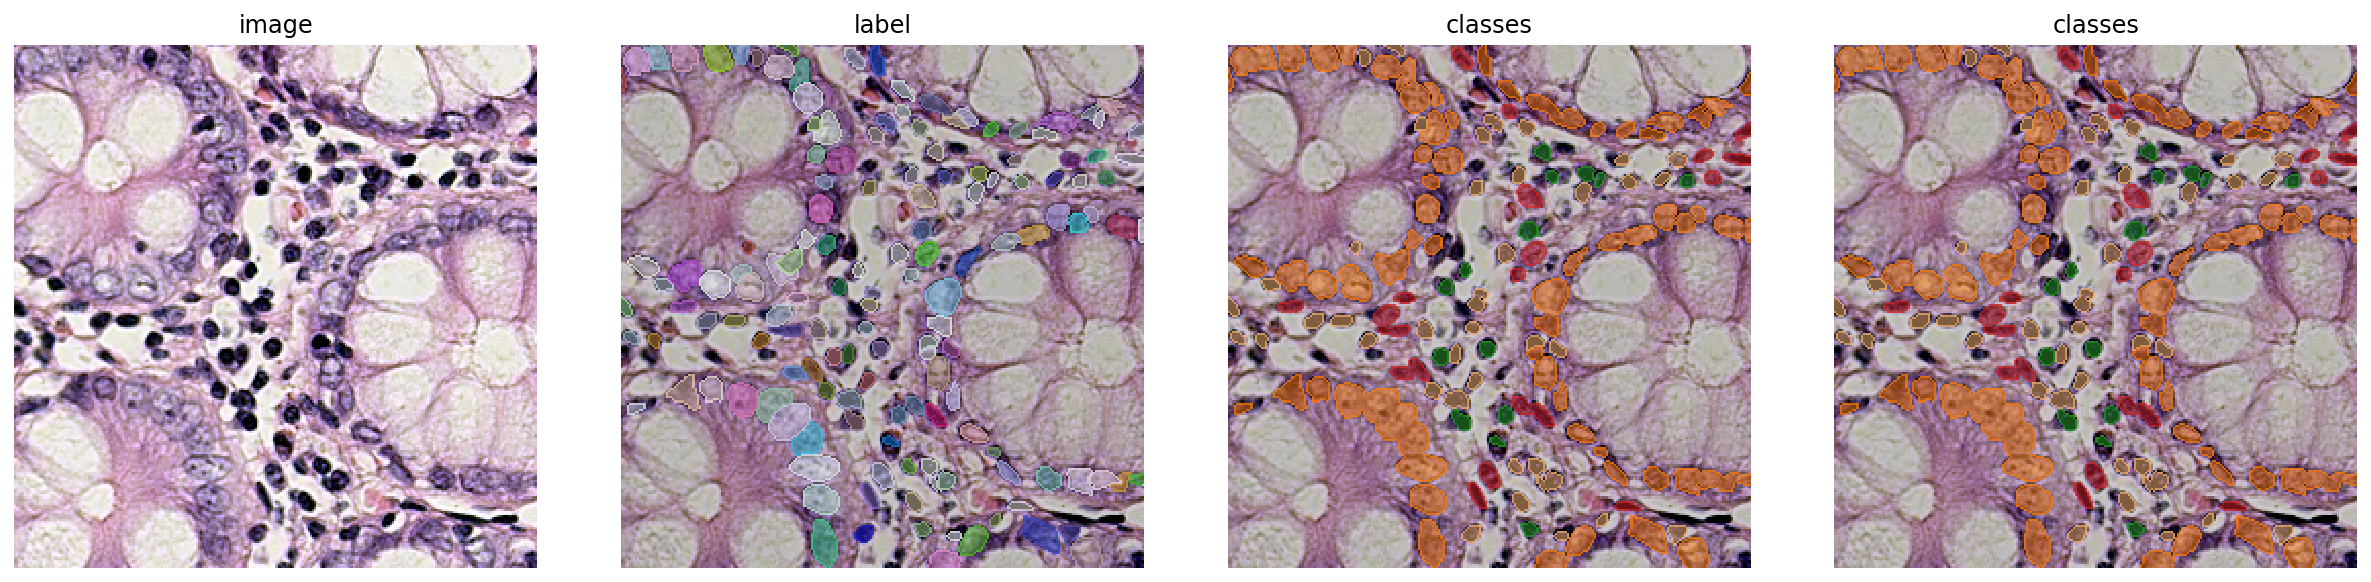

In [104]:
 #plot an example 
i = min(8, len(X)-1)
img, lbl, cls, cls_dict = X[i], Y[i], C[i], Cd[i]
ax = plot_img_label(img,lbl,cls,cls_dict, n_classes)
for a in ax: a.axis("off");

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [105]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

### Multi-class model

* Set the `n_classes` variable to the number of object classes in the `Config` object.
* Set the `classes` variable in `model.train` to a list of class dictionaries for every training image/label pair.

In [106]:
# 32 is a good default choice
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    n_classes    = n_classes,   # set the number of object classes
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=33, n_classes=6, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1, 1, 1, 1, 1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2, 1), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), u

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': 6,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2, 1),
 'train_class_weights': (1, 1, 1, 1, 1, 1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_

In [107]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    #limit_gpu_memory(None, allow_growth=True)
    # alternatively, adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)    

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [108]:
model = StarDist2D(conf, name='stardist_multiclass_CoNIC_2022_run_03', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [109]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [10.  10.5]
network field of view :  [94 93]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [110]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


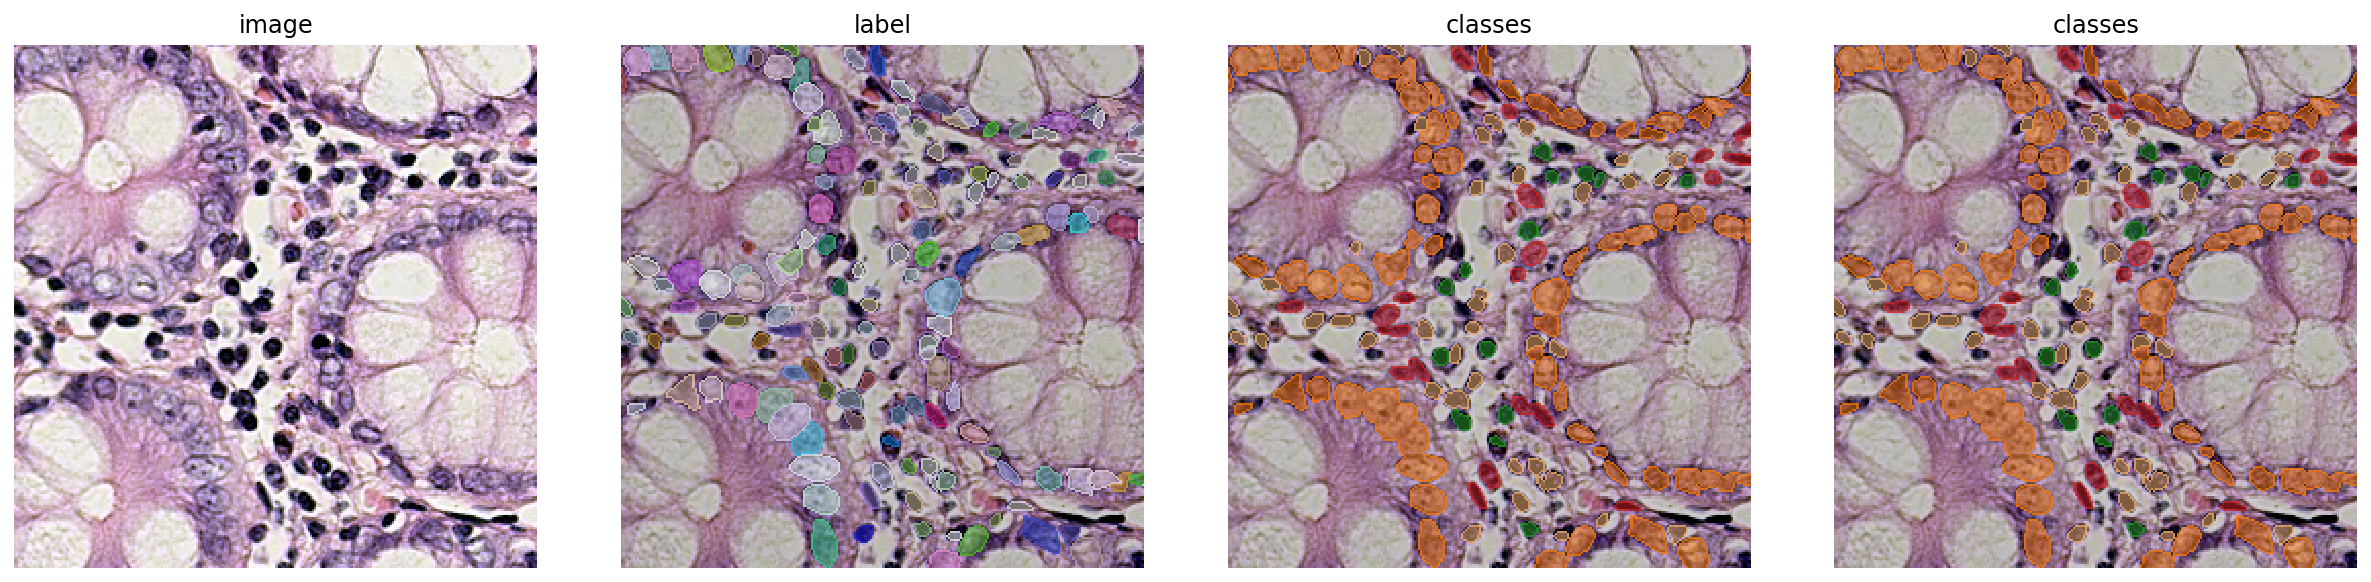

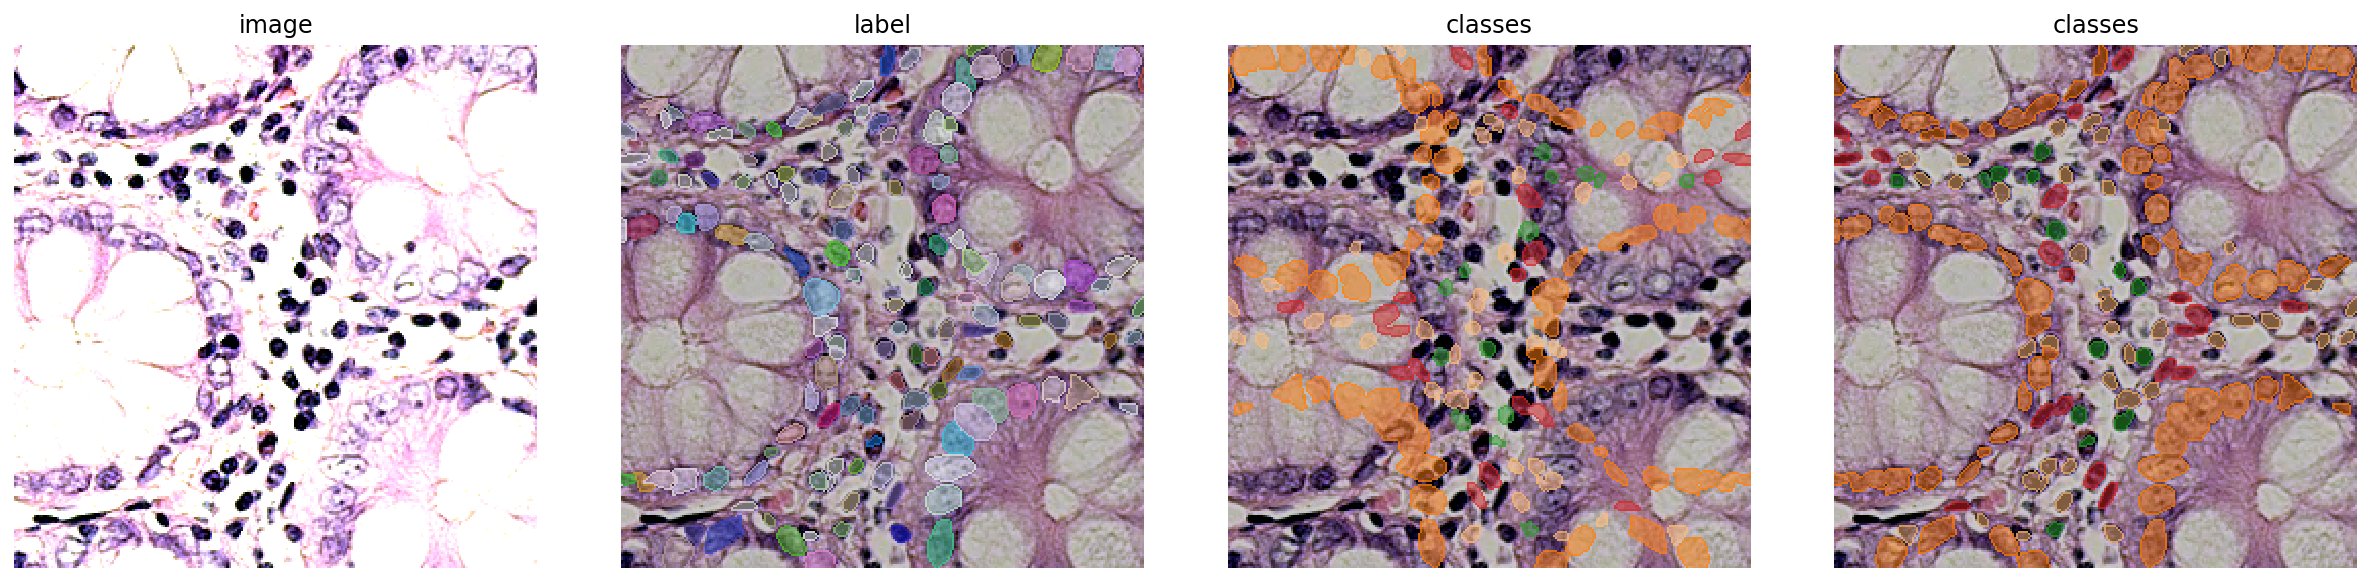

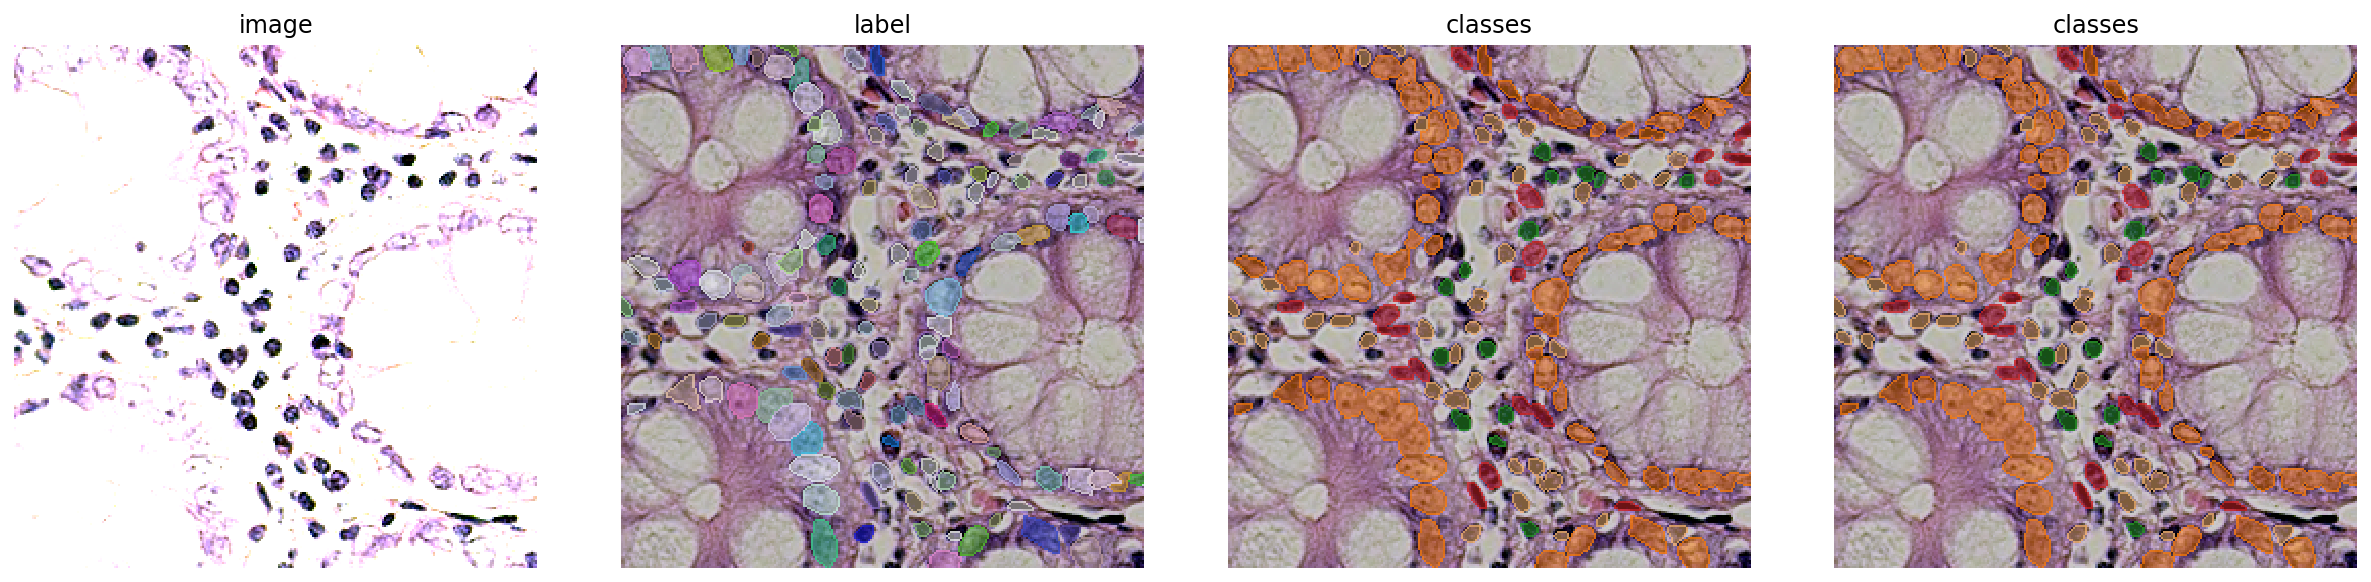

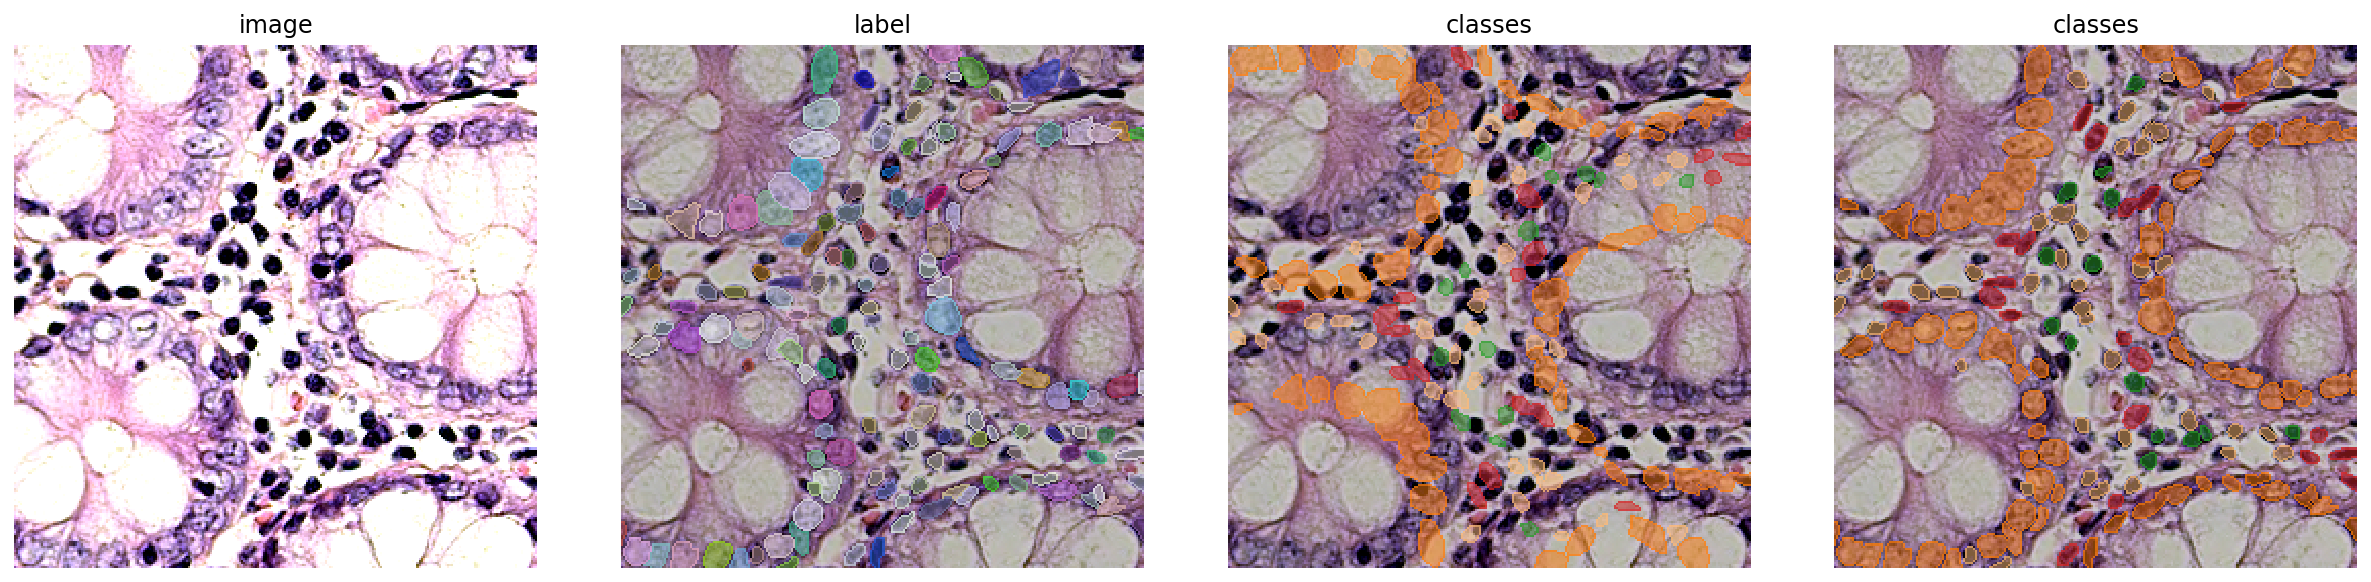

In [111]:
# plot some augmented examples
i = min(8, len(X)-1)
img, lbl,cls, cls_dict = X[i], Y[i],C[i], Cd[i]
plot_img_label(img,lbl,cls,cls_dict, n_classes)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug,lbl_aug,cls, cls_dict, n_classes)
None;



# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [112]:
model.train(X_trn,Y_trn, classes=C_trn, validation_data=(X_val,Y_val,C_val), augmenter=augmenter,
            epochs=500) # 200 epochs seem to be enough for synthetic demo dataset

Epoch 1/500
100/100 [==============================] - 28s 279ms/step - loss: 1.8379 - prob_loss: 0.3411 - dist_loss: 3.8122 - prob_class_loss: 0.7343 - prob_kld: 0.2490 - dist_relevant_mae: 3.8119 - dist_relevant_mse: 25.9121 - dist_dist_iou_metric: 0.1565 - val_loss: 1.6905 - val_prob_loss: 0.3259 - val_dist_loss: 3.4898 - val_prob_class_loss: 0.6666 - val_prob_kld: 0.2375 - val_dist_relevant_mae: 3.4896 - val_dist_relevant_mse: 23.4353 - val_dist_dist_iou_metric: 0.1433
Epoch 2/500
100/100 [==============================] - 27s 271ms/step - loss: 1.4431 - prob_loss: 0.2748 - dist_loss: 3.0569 - prob_class_loss: 0.5569 - prob_kld: 0.1802 - dist_relevant_mae: 3.0564 - dist_relevant_mse: 17.8006 - dist_dist_iou_metric: 0.2829 - val_loss: 1.3229 - val_prob_loss: 0.2276 - val_dist_loss: 3.1198 - val_prob_class_loss: 0.4713 - val_prob_kld: 0.1392 - val_dist_relevant_mae: 3.1195 - val_dist_relevant_mse: 19.0801 - val_dist_dist_iou_metric: 0.2125
Epoch 3/500
100/100 [=======================

100/100 [==============================] - 26s 260ms/step - loss: 0.8392 - prob_loss: 0.1743 - dist_loss: 1.8144 - prob_class_loss: 0.3020 - prob_kld: 0.0828 - dist_relevant_mae: 1.8140 - dist_relevant_mse: 7.8254 - dist_dist_iou_metric: 0.5378 - val_loss: 0.8208 - val_prob_loss: 0.1675 - val_dist_loss: 1.8461 - val_prob_class_loss: 0.2841 - val_prob_kld: 0.0791 - val_dist_relevant_mae: 1.8457 - val_dist_relevant_mse: 7.7311 - val_dist_dist_iou_metric: 0.5534
Epoch 19/500
100/100 [==============================] - 26s 260ms/step - loss: 0.8312 - prob_loss: 0.1745 - dist_loss: 1.7822 - prob_class_loss: 0.3003 - prob_kld: 0.0833 - dist_relevant_mae: 1.7818 - dist_relevant_mse: 7.6541 - dist_dist_iou_metric: 0.5405 - val_loss: 0.8350 - val_prob_loss: 0.1749 - val_dist_loss: 1.8393 - val_prob_class_loss: 0.2922 - val_prob_kld: 0.0865 - val_dist_relevant_mae: 1.8389 - val_dist_relevant_mse: 8.2581 - val_dist_dist_iou_metric: 0.5203
Epoch 20/500
100/100 [==============================] - 26s

100/100 [==============================] - 26s 262ms/step - loss: 0.7402 - prob_loss: 0.1696 - dist_loss: 1.5706 - prob_class_loss: 0.2565 - prob_kld: 0.0744 - dist_relevant_mae: 1.5702 - dist_relevant_mse: 6.2825 - dist_dist_iou_metric: 0.5875 - val_loss: 0.7071 - val_prob_loss: 0.1568 - val_dist_loss: 1.5471 - val_prob_class_loss: 0.2409 - val_prob_kld: 0.0683 - val_dist_relevant_mae: 1.5467 - val_dist_relevant_mse: 6.3956 - val_dist_dist_iou_metric: 0.5925
Epoch 36/500
100/100 [==============================] - 26s 257ms/step - loss: 0.6956 - prob_loss: 0.1565 - dist_loss: 1.5145 - prob_class_loss: 0.2362 - prob_kld: 0.0674 - dist_relevant_mae: 1.5142 - dist_relevant_mse: 5.9434 - dist_dist_iou_metric: 0.6016 - val_loss: 0.7149 - val_prob_loss: 0.1604 - val_dist_loss: 1.5457 - val_prob_class_loss: 0.2453 - val_prob_kld: 0.0720 - val_dist_relevant_mae: 1.5454 - val_dist_relevant_mse: 6.3225 - val_dist_dist_iou_metric: 0.5971
Epoch 37/500
100/100 [==============================] - 26s

100/100 [==============================] - 26s 262ms/step - loss: 0.6740 - prob_loss: 0.1589 - dist_loss: 1.4004 - prob_class_loss: 0.2350 - prob_kld: 0.0661 - dist_relevant_mae: 1.4000 - dist_relevant_mse: 5.2590 - dist_dist_iou_metric: 0.6283 - val_loss: 0.6474 - val_prob_loss: 0.1504 - val_dist_loss: 1.4140 - val_prob_class_loss: 0.2142 - val_prob_kld: 0.0620 - val_dist_relevant_mae: 1.4136 - val_dist_relevant_mse: 5.4214 - val_dist_dist_iou_metric: 0.6262
Epoch 53/500
100/100 [==============================] - 26s 257ms/step - loss: 0.6651 - prob_loss: 0.1548 - dist_loss: 1.4156 - prob_class_loss: 0.2271 - prob_kld: 0.0641 - dist_relevant_mae: 1.4153 - dist_relevant_mse: 5.2443 - dist_dist_iou_metric: 0.6280 - val_loss: 0.6567 - val_prob_loss: 0.1508 - val_dist_loss: 1.4374 - val_prob_class_loss: 0.2184 - val_prob_kld: 0.0624 - val_dist_relevant_mae: 1.4371 - val_dist_relevant_mse: 5.7532 - val_dist_dist_iou_metric: 0.6158
Epoch 54/500
100/100 [==============================] - 26s

100/100 [==============================] - 26s 256ms/step - loss: 0.6204 - prob_loss: 0.1464 - dist_loss: 1.3351 - prob_class_loss: 0.2070 - prob_kld: 0.0582 - dist_relevant_mae: 1.3347 - dist_relevant_mse: 4.9689 - dist_dist_iou_metric: 0.6486 - val_loss: 0.6160 - val_prob_loss: 0.1469 - val_dist_loss: 1.3250 - val_prob_class_loss: 0.2041 - val_prob_kld: 0.0585 - val_dist_relevant_mae: 1.3247 - val_dist_relevant_mse: 4.8615 - val_dist_dist_iou_metric: 0.6494
Epoch 70/500
100/100 [==============================] - 26s 258ms/step - loss: 0.6250 - prob_loss: 0.1506 - dist_loss: 1.2946 - prob_class_loss: 0.2155 - prob_kld: 0.0610 - dist_relevant_mae: 1.2942 - dist_relevant_mse: 4.5077 - dist_dist_iou_metric: 0.6508 - val_loss: 0.6464 - val_prob_loss: 0.1501 - val_dist_loss: 1.3619 - val_prob_class_loss: 0.2239 - val_prob_kld: 0.0617 - val_dist_relevant_mae: 1.3615 - val_dist_relevant_mse: 5.1320 - val_dist_dist_iou_metric: 0.6388
Epoch 71/500
100/100 [==============================] - 26s

100/100 [==============================] - 26s 260ms/step - loss: 0.6231 - prob_loss: 0.1513 - dist_loss: 1.3029 - prob_class_loss: 0.2113 - prob_kld: 0.0588 - dist_relevant_mae: 1.3025 - dist_relevant_mse: 4.7001 - dist_dist_iou_metric: 0.6601 - val_loss: 0.6079 - val_prob_loss: 0.1454 - val_dist_loss: 1.2971 - val_prob_class_loss: 0.2030 - val_prob_kld: 0.0570 - val_dist_relevant_mae: 1.2967 - val_dist_relevant_mse: 4.6413 - val_dist_dist_iou_metric: 0.6603
Epoch 87/500
100/100 [==============================] - 26s 258ms/step - loss: 0.6285 - prob_loss: 0.1522 - dist_loss: 1.3063 - prob_class_loss: 0.2151 - prob_kld: 0.0613 - dist_relevant_mae: 1.3059 - dist_relevant_mse: 4.6319 - dist_dist_iou_metric: 0.6552 - val_loss: 0.6104 - val_prob_loss: 0.1475 - val_dist_loss: 1.2887 - val_prob_class_loss: 0.2053 - val_prob_kld: 0.0590 - val_dist_relevant_mae: 1.2883 - val_dist_relevant_mse: 4.6192 - val_dist_dist_iou_metric: 0.6598
Epoch 88/500
100/100 [==============================] - 26s

100/100 [==============================] - 26s 256ms/step - loss: 0.5895 - prob_loss: 0.1451 - dist_loss: 1.2456 - prob_class_loss: 0.1953 - prob_kld: 0.0557 - dist_relevant_mae: 1.2452 - dist_relevant_mse: 4.2921 - dist_dist_iou_metric: 0.6717 - val_loss: 0.5906 - val_prob_loss: 0.1454 - val_dist_loss: 1.2471 - val_prob_class_loss: 0.1957 - val_prob_kld: 0.0570 - val_dist_relevant_mae: 1.2467 - val_dist_relevant_mse: 4.3531 - val_dist_dist_iou_metric: 0.6735
Epoch 104/500
100/100 [==============================] - 26s 259ms/step - loss: 0.6028 - prob_loss: 0.1495 - dist_loss: 1.2314 - prob_class_loss: 0.2070 - prob_kld: 0.0584 - dist_relevant_mae: 1.2311 - dist_relevant_mse: 4.1796 - dist_dist_iou_metric: 0.6705 - val_loss: 0.5918 - val_prob_loss: 0.1437 - val_dist_loss: 1.2515 - val_prob_class_loss: 0.1978 - val_prob_kld: 0.0553 - val_dist_relevant_mae: 1.2511 - val_dist_relevant_mse: 4.4464 - val_dist_dist_iou_metric: 0.6667
Epoch 105/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 257ms/step - loss: 0.5806 - prob_loss: 0.1437 - dist_loss: 1.2214 - prob_class_loss: 0.1926 - prob_kld: 0.0546 - dist_relevant_mae: 1.2211 - dist_relevant_mse: 4.2022 - dist_dist_iou_metric: 0.6764 - val_loss: 0.5835 - val_prob_loss: 0.1432 - val_dist_loss: 1.2375 - val_prob_class_loss: 0.1928 - val_prob_kld: 0.0548 - val_dist_relevant_mae: 1.2372 - val_dist_relevant_mse: 4.3071 - val_dist_dist_iou_metric: 0.6815
Epoch 121/500
100/100 [==============================] - 26s 258ms/step - loss: 0.5970 - prob_loss: 0.1473 - dist_loss: 1.2260 - prob_class_loss: 0.2045 - prob_kld: 0.0572 - dist_relevant_mae: 1.2257 - dist_relevant_mse: 4.2757 - dist_dist_iou_metric: 0.6735 - val_loss: 0.5803 - val_prob_loss: 0.1434 - val_dist_loss: 1.2240 - val_prob_class_loss: 0.1921 - val_prob_kld: 0.0550 - val_dist_relevant_mae: 1.2237 - val_dist_relevant_mse: 4.2384 - val_dist_dist_iou_metric: 0.6764
Epoch 122/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 260ms/step - loss: 0.5869 - prob_loss: 0.1486 - dist_loss: 1.1892 - prob_class_loss: 0.2005 - prob_kld: 0.0558 - dist_relevant_mae: 1.1889 - dist_relevant_mse: 3.9795 - dist_dist_iou_metric: 0.6837 - val_loss: 0.5746 - val_prob_loss: 0.1428 - val_dist_loss: 1.2157 - val_prob_class_loss: 0.1887 - val_prob_kld: 0.0544 - val_dist_relevant_mae: 1.2154 - val_dist_relevant_mse: 4.2181 - val_dist_dist_iou_metric: 0.6764
Epoch 138/500
100/100 [==============================] - 26s 259ms/step - loss: 0.5853 - prob_loss: 0.1464 - dist_loss: 1.2021 - prob_class_loss: 0.1985 - prob_kld: 0.0562 - dist_relevant_mae: 1.2017 - dist_relevant_mse: 4.1637 - dist_dist_iou_metric: 0.6791 - val_loss: 0.5784 - val_prob_loss: 0.1423 - val_dist_loss: 1.2326 - val_prob_class_loss: 0.1896 - val_prob_kld: 0.0538 - val_dist_relevant_mae: 1.2322 - val_dist_relevant_mse: 4.2159 - val_dist_dist_iou_metric: 0.6843
Epoch 139/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 260ms/step - loss: 0.5770 - prob_loss: 0.1464 - dist_loss: 1.1653 - prob_class_loss: 0.1975 - prob_kld: 0.0559 - dist_relevant_mae: 1.1649 - dist_relevant_mse: 3.8611 - dist_dist_iou_metric: 0.6868 - val_loss: 0.5627 - val_prob_loss: 0.1415 - val_dist_loss: 1.1863 - val_prob_class_loss: 0.1840 - val_prob_kld: 0.0531 - val_dist_relevant_mae: 1.1859 - val_dist_relevant_mse: 4.0626 - val_dist_dist_iou_metric: 0.6924
Epoch 155/500
100/100 [==============================] - 26s 262ms/step - loss: 0.5928 - prob_loss: 0.1528 - dist_loss: 1.1943 - prob_class_loss: 0.2012 - prob_kld: 0.0576 - dist_relevant_mae: 1.1940 - dist_relevant_mse: 4.1016 - dist_dist_iou_metric: 0.6839 - val_loss: 0.5602 - val_prob_loss: 0.1409 - val_dist_loss: 1.1819 - val_prob_class_loss: 0.1829 - val_prob_kld: 0.0525 - val_dist_relevant_mae: 1.1815 - val_dist_relevant_mse: 4.0803 - val_dist_dist_iou_metric: 0.6874
Epoch 156/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 261ms/step - loss: 0.5770 - prob_loss: 0.1494 - dist_loss: 1.1690 - prob_class_loss: 0.1938 - prob_kld: 0.0557 - dist_relevant_mae: 1.1687 - dist_relevant_mse: 3.8996 - dist_dist_iou_metric: 0.6883 - val_loss: 0.5672 - val_prob_loss: 0.1421 - val_dist_loss: 1.1792 - val_prob_class_loss: 0.1893 - val_prob_kld: 0.0536 - val_dist_relevant_mae: 1.1789 - val_dist_relevant_mse: 4.0180 - val_dist_dist_iou_metric: 0.6857
Epoch 172/500
100/100 [==============================] - 26s 260ms/step - loss: 0.5685 - prob_loss: 0.1458 - dist_loss: 1.1582 - prob_class_loss: 0.1911 - prob_kld: 0.0546 - dist_relevant_mae: 1.1578 - dist_relevant_mse: 3.8191 - dist_dist_iou_metric: 0.6890 - val_loss: 0.5572 - val_prob_loss: 0.1409 - val_dist_loss: 1.1666 - val_prob_class_loss: 0.1830 - val_prob_kld: 0.0525 - val_dist_relevant_mae: 1.1663 - val_dist_relevant_mse: 4.0058 - val_dist_dist_iou_metric: 0.6939
Epoch 173/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 258ms/step - loss: 0.5687 - prob_loss: 0.1466 - dist_loss: 1.1739 - prob_class_loss: 0.1873 - prob_kld: 0.0545 - dist_relevant_mae: 1.1736 - dist_relevant_mse: 3.9014 - dist_dist_iou_metric: 0.6917 - val_loss: 0.5554 - val_prob_loss: 0.1410 - val_dist_loss: 1.1610 - val_prob_class_loss: 0.1823 - val_prob_kld: 0.0525 - val_dist_relevant_mae: 1.1607 - val_dist_relevant_mse: 3.9231 - val_dist_dist_iou_metric: 0.6945
Epoch 189/500
100/100 [==============================] - 26s 258ms/step - loss: 0.5542 - prob_loss: 0.1424 - dist_loss: 1.1351 - prob_class_loss: 0.1847 - prob_kld: 0.0526 - dist_relevant_mae: 1.1348 - dist_relevant_mse: 3.8104 - dist_dist_iou_metric: 0.6980 - val_loss: 0.5562 - val_prob_loss: 0.1409 - val_dist_loss: 1.1646 - val_prob_class_loss: 0.1824 - val_prob_kld: 0.0524 - val_dist_relevant_mae: 1.1643 - val_dist_relevant_mse: 4.0065 - val_dist_dist_iou_metric: 0.6918
Epoch 190/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 259ms/step - loss: 0.5610 - prob_loss: 0.1445 - dist_loss: 1.1319 - prob_class_loss: 0.1902 - prob_kld: 0.0536 - dist_relevant_mae: 1.1316 - dist_relevant_mse: 3.7694 - dist_dist_iou_metric: 0.6950 - val_loss: 0.5625 - val_prob_loss: 0.1413 - val_dist_loss: 1.1628 - val_prob_class_loss: 0.1887 - val_prob_kld: 0.0529 - val_dist_relevant_mae: 1.1624 - val_dist_relevant_mse: 3.9649 - val_dist_dist_iou_metric: 0.6980
Epoch 206/500
100/100 [==============================] - 26s 261ms/step - loss: 0.5738 - prob_loss: 0.1492 - dist_loss: 1.1584 - prob_class_loss: 0.1929 - prob_kld: 0.0553 - dist_relevant_mae: 1.1581 - dist_relevant_mse: 3.9172 - dist_dist_iou_metric: 0.6928 - val_loss: 0.5459 - val_prob_loss: 0.1398 - val_dist_loss: 1.1466 - val_prob_class_loss: 0.1767 - val_prob_kld: 0.0514 - val_dist_relevant_mae: 1.1462 - val_dist_relevant_mse: 3.8828 - val_dist_dist_iou_metric: 0.7007
Epoch 207/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 261ms/step - loss: 0.5691 - prob_loss: 0.1490 - dist_loss: 1.1571 - prob_class_loss: 0.1887 - prob_kld: 0.0545 - dist_relevant_mae: 1.1568 - dist_relevant_mse: 3.8828 - dist_dist_iou_metric: 0.6949 - val_loss: 0.5528 - val_prob_loss: 0.1396 - val_dist_loss: 1.1508 - val_prob_class_loss: 0.1830 - val_prob_kld: 0.0512 - val_dist_relevant_mae: 1.1505 - val_dist_relevant_mse: 3.9727 - val_dist_dist_iou_metric: 0.6925
Epoch 223/500
100/100 [==============================] - 26s 259ms/step - loss: 0.5595 - prob_loss: 0.1445 - dist_loss: 1.1444 - prob_class_loss: 0.1861 - prob_kld: 0.0545 - dist_relevant_mae: 1.1440 - dist_relevant_mse: 3.7925 - dist_dist_iou_metric: 0.6935 - val_loss: 0.5452 - val_prob_loss: 0.1395 - val_dist_loss: 1.1469 - val_prob_class_loss: 0.1763 - val_prob_kld: 0.0511 - val_dist_relevant_mae: 1.1466 - val_dist_relevant_mse: 3.9240 - val_dist_dist_iou_metric: 0.6921
Epoch 224/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 259ms/step - loss: 0.5384 - prob_loss: 0.1390 - dist_loss: 1.1148 - prob_class_loss: 0.1765 - prob_kld: 0.0511 - dist_relevant_mae: 1.1144 - dist_relevant_mse: 3.6122 - dist_dist_iou_metric: 0.7009 - val_loss: 0.5422 - val_prob_loss: 0.1396 - val_dist_loss: 1.1350 - val_prob_class_loss: 0.1756 - val_prob_kld: 0.0512 - val_dist_relevant_mae: 1.1347 - val_dist_relevant_mse: 3.8178 - val_dist_dist_iou_metric: 0.6995
Epoch 240/500
100/100 [==============================] - 26s 261ms/step - loss: 0.5611 - prob_loss: 0.1477 - dist_loss: 1.1303 - prob_class_loss: 0.1873 - prob_kld: 0.0540 - dist_relevant_mae: 1.1300 - dist_relevant_mse: 3.7362 - dist_dist_iou_metric: 0.6979 - val_loss: 0.5410 - val_prob_loss: 0.1393 - val_dist_loss: 1.1311 - val_prob_class_loss: 0.1755 - val_prob_kld: 0.0508 - val_dist_relevant_mae: 1.1308 - val_dist_relevant_mse: 3.8349 - val_dist_dist_iou_metric: 0.7033
Epoch 241/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 258ms/step - loss: 0.5510 - prob_loss: 0.1440 - dist_loss: 1.1399 - prob_class_loss: 0.1790 - prob_kld: 0.0524 - dist_relevant_mae: 1.1396 - dist_relevant_mse: 3.8520 - dist_dist_iou_metric: 0.6995 - val_loss: 0.5496 - val_prob_loss: 0.1401 - val_dist_loss: 1.1368 - val_prob_class_loss: 0.1822 - val_prob_kld: 0.0517 - val_dist_relevant_mae: 1.1365 - val_dist_relevant_mse: 3.9206 - val_dist_dist_iou_metric: 0.6998
Epoch 257/500
100/100 [==============================] - 26s 259ms/step - loss: 0.5468 - prob_loss: 0.1442 - dist_loss: 1.1044 - prob_class_loss: 0.1816 - prob_kld: 0.0526 - dist_relevant_mae: 1.1041 - dist_relevant_mse: 3.5616 - dist_dist_iou_metric: 0.7032 - val_loss: 0.5415 - val_prob_loss: 0.1389 - val_dist_loss: 1.1399 - val_prob_class_loss: 0.1746 - val_prob_kld: 0.0505 - val_dist_relevant_mae: 1.1396 - val_dist_relevant_mse: 3.8707 - val_dist_dist_iou_metric: 0.6960
Epoch 258/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 260ms/step - loss: 0.5603 - prob_loss: 0.1473 - dist_loss: 1.1293 - prob_class_loss: 0.1871 - prob_kld: 0.0538 - dist_relevant_mae: 1.1289 - dist_relevant_mse: 3.7553 - dist_dist_iou_metric: 0.7020 - val_loss: 0.5395 - val_prob_loss: 0.1394 - val_dist_loss: 1.1196 - val_prob_class_loss: 0.1761 - val_prob_kld: 0.0510 - val_dist_relevant_mae: 1.1192 - val_dist_relevant_mse: 3.7499 - val_dist_dist_iou_metric: 0.7106
Epoch 274/500
100/100 [==============================] - 26s 259ms/step - loss: 0.5589 - prob_loss: 0.1452 - dist_loss: 1.1390 - prob_class_loss: 0.1859 - prob_kld: 0.0525 - dist_relevant_mae: 1.1387 - dist_relevant_mse: 3.8392 - dist_dist_iou_metric: 0.7011 - val_loss: 0.5485 - val_prob_loss: 0.1400 - val_dist_loss: 1.1436 - val_prob_class_loss: 0.1797 - val_prob_kld: 0.0516 - val_dist_relevant_mae: 1.1432 - val_dist_relevant_mse: 3.8479 - val_dist_dist_iou_metric: 0.6994
Epoch 275/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 258ms/step - loss: 0.5463 - prob_loss: 0.1420 - dist_loss: 1.1082 - prob_class_loss: 0.1826 - prob_kld: 0.0526 - dist_relevant_mae: 1.1079 - dist_relevant_mse: 3.5816 - dist_dist_iou_metric: 0.7014 - val_loss: 0.5492 - val_prob_loss: 0.1402 - val_dist_loss: 1.1484 - val_prob_class_loss: 0.1793 - val_prob_kld: 0.0518 - val_dist_relevant_mae: 1.1481 - val_dist_relevant_mse: 3.8699 - val_dist_dist_iou_metric: 0.6919
Epoch 291/500
100/100 [==============================] - 26s 259ms/step - loss: 0.5513 - prob_loss: 0.1448 - dist_loss: 1.1204 - prob_class_loss: 0.1824 - prob_kld: 0.0527 - dist_relevant_mae: 1.1201 - dist_relevant_mse: 3.6488 - dist_dist_iou_metric: 0.7043 - val_loss: 0.5366 - val_prob_loss: 0.1388 - val_dist_loss: 1.1228 - val_prob_class_loss: 0.1732 - val_prob_kld: 0.0504 - val_dist_relevant_mae: 1.1225 - val_dist_relevant_mse: 3.7764 - val_dist_dist_iou_metric: 0.7028
Epoch 292/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 257ms/step - loss: 0.5353 - prob_loss: 0.1398 - dist_loss: 1.1258 - prob_class_loss: 0.1704 - prob_kld: 0.0501 - dist_relevant_mae: 1.1254 - dist_relevant_mse: 3.7689 - dist_dist_iou_metric: 0.7051 - val_loss: 0.5365 - val_prob_loss: 0.1389 - val_dist_loss: 1.1248 - val_prob_class_loss: 0.1726 - val_prob_kld: 0.0505 - val_dist_relevant_mae: 1.1245 - val_dist_relevant_mse: 3.8168 - val_dist_dist_iou_metric: 0.7037
Epoch 308/500
100/100 [==============================] - 26s 259ms/step - loss: 0.5398 - prob_loss: 0.1428 - dist_loss: 1.0968 - prob_class_loss: 0.1777 - prob_kld: 0.0513 - dist_relevant_mae: 1.0965 - dist_relevant_mse: 3.5162 - dist_dist_iou_metric: 0.7060 - val_loss: 0.5385 - val_prob_loss: 0.1391 - val_dist_loss: 1.1316 - val_prob_class_loss: 0.1730 - val_prob_kld: 0.0507 - val_dist_relevant_mae: 1.1312 - val_dist_relevant_mse: 3.7746 - val_dist_dist_iou_metric: 0.7024
Epoch 309/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 260ms/step - loss: 0.5291 - prob_loss: 0.1401 - dist_loss: 1.0688 - prob_class_loss: 0.1753 - prob_kld: 0.0503 - dist_relevant_mae: 1.0685 - dist_relevant_mse: 3.3811 - dist_dist_iou_metric: 0.7128 - val_loss: 0.5332 - val_prob_loss: 0.1389 - val_dist_loss: 1.1064 - val_prob_class_loss: 0.1731 - val_prob_kld: 0.0504 - val_dist_relevant_mae: 1.1061 - val_dist_relevant_mse: 3.6881 - val_dist_dist_iou_metric: 0.7101
Epoch 325/500
100/100 [==============================] - 26s 261ms/step - loss: 0.5498 - prob_loss: 0.1469 - dist_loss: 1.1191 - prob_class_loss: 0.1790 - prob_kld: 0.0524 - dist_relevant_mae: 1.1188 - dist_relevant_mse: 3.6751 - dist_dist_iou_metric: 0.7046 - val_loss: 0.5321 - val_prob_loss: 0.1386 - val_dist_loss: 1.1082 - val_prob_class_loss: 0.1718 - val_prob_kld: 0.0502 - val_dist_relevant_mae: 1.1079 - val_dist_relevant_mse: 3.7094 - val_dist_dist_iou_metric: 0.7063
Epoch 326/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 259ms/step - loss: 0.5271 - prob_loss: 0.1412 - dist_loss: 1.0629 - prob_class_loss: 0.1733 - prob_kld: 0.0505 - dist_relevant_mae: 1.0626 - dist_relevant_mse: 3.4062 - dist_dist_iou_metric: 0.7108 - val_loss: 0.6021 - val_prob_loss: 0.1417 - val_dist_loss: 1.1447 - val_prob_class_loss: 0.2314 - val_prob_kld: 0.0533 - val_dist_relevant_mae: 1.1444 - val_dist_relevant_mse: 3.8722 - val_dist_dist_iou_metric: 0.7022
Epoch 342/500
100/100 [==============================] - 26s 260ms/step - loss: 0.5548 - prob_loss: 0.1465 - dist_loss: 1.1246 - prob_class_loss: 0.1834 - prob_kld: 0.0527 - dist_relevant_mae: 1.1243 - dist_relevant_mse: 3.8316 - dist_dist_iou_metric: 0.7056 - val_loss: 0.5276 - val_prob_loss: 0.1377 - val_dist_loss: 1.0993 - val_prob_class_loss: 0.1700 - val_prob_kld: 0.0493 - val_dist_relevant_mae: 1.0990 - val_dist_relevant_mse: 3.6652 - val_dist_dist_iou_metric: 0.7102
Epoch 343/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 259ms/step - loss: 0.5337 - prob_loss: 0.1418 - dist_loss: 1.1025 - prob_class_loss: 0.1714 - prob_kld: 0.0497 - dist_relevant_mae: 1.1022 - dist_relevant_mse: 3.5881 - dist_dist_iou_metric: 0.7115 - val_loss: 0.5264 - val_prob_loss: 0.1375 - val_dist_loss: 1.0988 - val_prob_class_loss: 0.1692 - val_prob_kld: 0.0491 - val_dist_relevant_mae: 1.0985 - val_dist_relevant_mse: 3.6891 - val_dist_dist_iou_metric: 0.7073
Epoch 359/500
100/100 [==============================] - 26s 260ms/step - loss: 0.5386 - prob_loss: 0.1461 - dist_loss: 1.0786 - prob_class_loss: 0.1769 - prob_kld: 0.0519 - dist_relevant_mae: 1.0783 - dist_relevant_mse: 3.4239 - dist_dist_iou_metric: 0.7110 - val_loss: 0.5375 - val_prob_loss: 0.1379 - val_dist_loss: 1.1060 - val_prob_class_loss: 0.1784 - val_prob_kld: 0.0495 - val_dist_relevant_mae: 1.1056 - val_dist_relevant_mse: 3.7586 - val_dist_dist_iou_metric: 0.7048
Epoch 360/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 257ms/step - loss: 0.5319 - prob_loss: 0.1399 - dist_loss: 1.0970 - prob_class_loss: 0.1726 - prob_kld: 0.0497 - dist_relevant_mae: 1.0967 - dist_relevant_mse: 3.5971 - dist_dist_iou_metric: 0.7105 - val_loss: 0.5289 - val_prob_loss: 0.1378 - val_dist_loss: 1.1015 - val_prob_class_loss: 0.1709 - val_prob_kld: 0.0493 - val_dist_relevant_mae: 1.1012 - val_dist_relevant_mse: 3.7275 - val_dist_dist_iou_metric: 0.7119
Epoch 376/500
100/100 [==============================] - 26s 262ms/step - loss: 0.5376 - prob_loss: 0.1460 - dist_loss: 1.0760 - prob_class_loss: 0.1764 - prob_kld: 0.0521 - dist_relevant_mae: 1.0757 - dist_relevant_mse: 3.4230 - dist_dist_iou_metric: 0.7113 - val_loss: 0.5277 - val_prob_loss: 0.1377 - val_dist_loss: 1.1132 - val_prob_class_loss: 0.1673 - val_prob_kld: 0.0493 - val_dist_relevant_mae: 1.1129 - val_dist_relevant_mse: 3.6670 - val_dist_dist_iou_metric: 0.7059
Epoch 377/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 258ms/step - loss: 0.5249 - prob_loss: 0.1419 - dist_loss: 1.0689 - prob_class_loss: 0.1692 - prob_kld: 0.0505 - dist_relevant_mae: 1.0686 - dist_relevant_mse: 3.3548 - dist_dist_iou_metric: 0.7124 - val_loss: 0.5328 - val_prob_loss: 0.1381 - val_dist_loss: 1.1068 - val_prob_class_loss: 0.1734 - val_prob_kld: 0.0496 - val_dist_relevant_mae: 1.1065 - val_dist_relevant_mse: 3.6907 - val_dist_dist_iou_metric: 0.7106
Epoch 393/500
100/100 [==============================] - 26s 260ms/step - loss: 0.5379 - prob_loss: 0.1446 - dist_loss: 1.0880 - prob_class_loss: 0.1758 - prob_kld: 0.0514 - dist_relevant_mae: 1.0876 - dist_relevant_mse: 3.4369 - dist_dist_iou_metric: 0.7109 - val_loss: 0.5348 - val_prob_loss: 0.1379 - val_dist_loss: 1.1050 - val_prob_class_loss: 0.1759 - val_prob_kld: 0.0494 - val_dist_relevant_mae: 1.1047 - val_dist_relevant_mse: 3.7523 - val_dist_dist_iou_metric: 0.7113
Epoch 394/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 258ms/step - loss: 0.5303 - prob_loss: 0.1422 - dist_loss: 1.0838 - prob_class_loss: 0.1713 - prob_kld: 0.0509 - dist_relevant_mae: 1.0835 - dist_relevant_mse: 3.5018 - dist_dist_iou_metric: 0.7104 - val_loss: 0.5259 - val_prob_loss: 0.1376 - val_dist_loss: 1.1050 - val_prob_class_loss: 0.1674 - val_prob_kld: 0.0491 - val_dist_relevant_mae: 1.1047 - val_dist_relevant_mse: 3.6581 - val_dist_dist_iou_metric: 0.7142
Epoch 410/500
100/100 [==============================] - 26s 260ms/step - loss: 0.5309 - prob_loss: 0.1439 - dist_loss: 1.0647 - prob_class_loss: 0.1740 - prob_kld: 0.0503 - dist_relevant_mae: 1.0643 - dist_relevant_mse: 3.3752 - dist_dist_iou_metric: 0.7171 - val_loss: 0.5307 - val_prob_loss: 0.1381 - val_dist_loss: 1.1066 - val_prob_class_loss: 0.1713 - val_prob_kld: 0.0497 - val_dist_relevant_mae: 1.1062 - val_dist_relevant_mse: 3.6769 - val_dist_dist_iou_metric: 0.7117
Epoch 411/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 255ms/step - loss: 0.5213 - prob_loss: 0.1372 - dist_loss: 1.0850 - prob_class_loss: 0.1670 - prob_kld: 0.0494 - dist_relevant_mae: 1.0847 - dist_relevant_mse: 3.5578 - dist_dist_iou_metric: 0.7112 - val_loss: 0.5237 - val_prob_loss: 0.1373 - val_dist_loss: 1.0864 - val_prob_class_loss: 0.1691 - val_prob_kld: 0.0489 - val_dist_relevant_mae: 1.0860 - val_dist_relevant_mse: 3.6086 - val_dist_dist_iou_metric: 0.7170
Epoch 427/500
100/100 [==============================] - 26s 261ms/step - loss: 0.5333 - prob_loss: 0.1458 - dist_loss: 1.0661 - prob_class_loss: 0.1742 - prob_kld: 0.0516 - dist_relevant_mae: 1.0658 - dist_relevant_mse: 3.3919 - dist_dist_iou_metric: 0.7157 - val_loss: 0.5271 - val_prob_loss: 0.1372 - val_dist_loss: 1.1037 - val_prob_class_loss: 0.1692 - val_prob_kld: 0.0488 - val_dist_relevant_mae: 1.1033 - val_dist_relevant_mse: 3.7202 - val_dist_dist_iou_metric: 0.7028
Epoch 428/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 258ms/step - loss: 0.5212 - prob_loss: 0.1403 - dist_loss: 1.0810 - prob_class_loss: 0.1648 - prob_kld: 0.0499 - dist_relevant_mae: 1.0807 - dist_relevant_mse: 3.5214 - dist_dist_iou_metric: 0.7110 - val_loss: 0.5224 - val_prob_loss: 0.1372 - val_dist_loss: 1.0812 - val_prob_class_loss: 0.1689 - val_prob_kld: 0.0488 - val_dist_relevant_mae: 1.0809 - val_dist_relevant_mse: 3.6224 - val_dist_dist_iou_metric: 0.7184
Epoch 444/500
100/100 [==============================] - 26s 259ms/step - loss: 0.5245 - prob_loss: 0.1397 - dist_loss: 1.0477 - prob_class_loss: 0.1753 - prob_kld: 0.0502 - dist_relevant_mae: 1.0474 - dist_relevant_mse: 3.2949 - dist_dist_iou_metric: 0.7146 - val_loss: 0.5279 - val_prob_loss: 0.1383 - val_dist_loss: 1.0975 - val_prob_class_loss: 0.1702 - val_prob_kld: 0.0499 - val_dist_relevant_mae: 1.0971 - val_dist_relevant_mse: 3.7544 - val_dist_dist_iou_metric: 0.7134
Epoch 445/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 256ms/step - loss: 0.5082 - prob_loss: 0.1358 - dist_loss: 1.0519 - prob_class_loss: 0.1621 - prob_kld: 0.0478 - dist_relevant_mae: 1.0516 - dist_relevant_mse: 3.3183 - dist_dist_iou_metric: 0.7184 - val_loss: 0.5462 - val_prob_loss: 0.1395 - val_dist_loss: 1.0987 - val_prob_class_loss: 0.1869 - val_prob_kld: 0.0511 - val_dist_relevant_mae: 1.0984 - val_dist_relevant_mse: 3.6659 - val_dist_dist_iou_metric: 0.7121
Epoch 461/500
100/100 [==============================] - 26s 258ms/step - loss: 0.5375 - prob_loss: 0.1417 - dist_loss: 1.1120 - prob_class_loss: 0.1735 - prob_kld: 0.0511 - dist_relevant_mae: 1.1116 - dist_relevant_mse: 3.7348 - dist_dist_iou_metric: 0.7086 - val_loss: 0.5312 - val_prob_loss: 0.1390 - val_dist_loss: 1.0945 - val_prob_class_loss: 0.1733 - val_prob_kld: 0.0506 - val_dist_relevant_mae: 1.0942 - val_dist_relevant_mse: 3.6574 - val_dist_dist_iou_metric: 0.7130
Epoch 462/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 256ms/step - loss: 0.5216 - prob_loss: 0.1384 - dist_loss: 1.0882 - prob_class_loss: 0.1656 - prob_kld: 0.0487 - dist_relevant_mae: 1.0879 - dist_relevant_mse: 3.5760 - dist_dist_iou_metric: 0.7140 - val_loss: 0.5194 - val_prob_loss: 0.1374 - val_dist_loss: 1.0824 - val_prob_class_loss: 0.1655 - val_prob_kld: 0.0489 - val_dist_relevant_mae: 1.0820 - val_dist_relevant_mse: 3.6465 - val_dist_dist_iou_metric: 0.7132
Epoch 478/500
100/100 [==============================] - 26s 258ms/step - loss: 0.5256 - prob_loss: 0.1408 - dist_loss: 1.0762 - prob_class_loss: 0.1696 - prob_kld: 0.0493 - dist_relevant_mae: 1.0759 - dist_relevant_mse: 3.5505 - dist_dist_iou_metric: 0.7156 - val_loss: 0.5211 - val_prob_loss: 0.1374 - val_dist_loss: 1.0793 - val_prob_class_loss: 0.1679 - val_prob_kld: 0.0489 - val_dist_relevant_mae: 1.0790 - val_dist_relevant_mse: 3.5841 - val_dist_dist_iou_metric: 0.7179
Epoch 479/500
100/100 [==============================] - 2

100/100 [==============================] - 26s 261ms/step - loss: 0.5374 - prob_loss: 0.1456 - dist_loss: 1.0633 - prob_class_loss: 0.1791 - prob_kld: 0.0524 - dist_relevant_mae: 1.0630 - dist_relevant_mse: 3.3872 - dist_dist_iou_metric: 0.7140 - val_loss: 0.5463 - val_prob_loss: 0.1402 - val_dist_loss: 1.1140 - val_prob_class_loss: 0.1833 - val_prob_kld: 0.0518 - val_dist_relevant_mae: 1.1137 - val_dist_relevant_mse: 3.7091 - val_dist_dist_iou_metric: 0.7090
Epoch 495/500
100/100 [==============================] - 26s 258ms/step - loss: 0.5223 - prob_loss: 0.1399 - dist_loss: 1.0714 - prob_class_loss: 0.1681 - prob_kld: 0.0501 - dist_relevant_mae: 1.0711 - dist_relevant_mse: 3.4351 - dist_dist_iou_metric: 0.7135 - val_loss: 0.5220 - val_prob_loss: 0.1370 - val_dist_loss: 1.0800 - val_prob_class_loss: 0.1690 - val_prob_kld: 0.0486 - val_dist_relevant_mae: 1.0796 - val_dist_relevant_mse: 3.6365 - val_dist_dist_iou_metric: 0.7178
Epoch 496/500
100/100 [==============================] - 2

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [113]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 16/20 [04:07<01:01, 15.49s/it, 0.499 -> 0.643]


Using optimized values: prob_thresh=0.498442, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.4984420387533079, 'nms': 0.3}

# Evaluation and Detection Performance

Predict for a single example image first.

In [114]:
i = 50
label, res = model.predict_instances(X_val[i], n_tiles=model._guess_n_tiles(X_val[i]))

In [115]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 

def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict

print(class_from_res(res))

{1: 6, 2: 2, 3: 6, 4: 6, 5: 2, 6: 2, 7: 2, 8: 6, 9: 6, 10: 2, 11: 2, 12: 2, 13: 6, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 6, 22: 2, 23: 2, 24: 4, 25: 2, 26: 6, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 6, 34: 2, 35: 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:title={'center':'image'}>,
 <AxesSubplot:title={'center':'GT'}>,
 <AxesSubplot:title={'center':'classes'}>,
 <AxesSubplot:title={'center':'classes'}>)

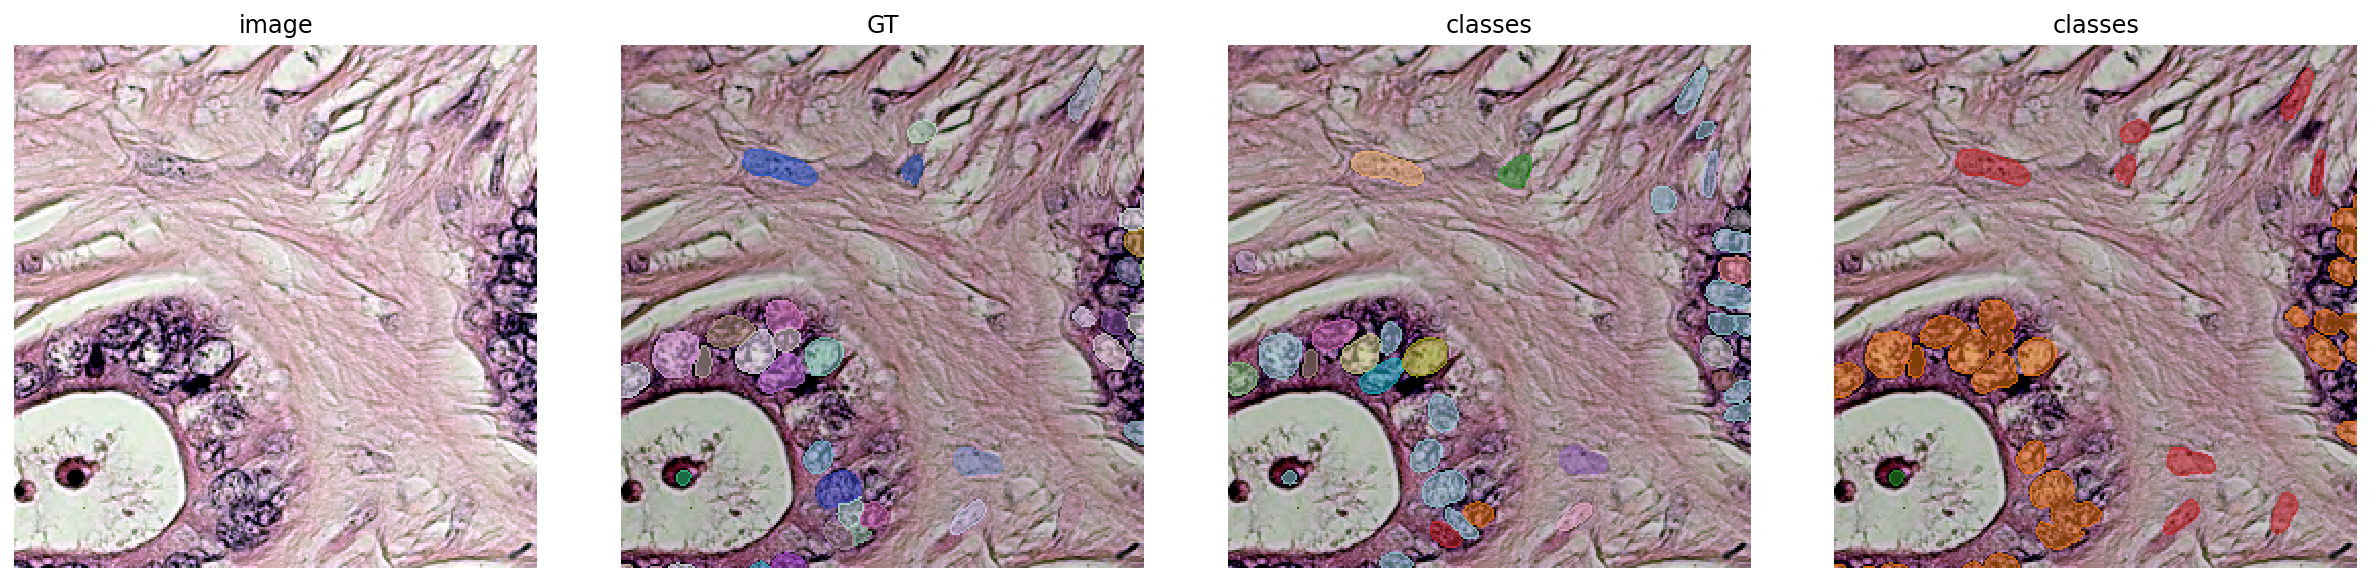

In [116]:
plot_img_label(X_val[i], Y_val[i],label, C_val[i], n_classes,       lbl_title="GT")


Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

First predict the labels for all validation images:

In [117]:
Y_val_pred, res_val_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_val[:])]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 717/717 [01:20<00:00,  8.89it/s]


Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [118]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.22s/it]


Example: Print all available matching statistics for $\tau=0.5$

In [119]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=11384, tp=63111, fn=16389, precision=0.8471843747902543, recall=0.7938490566037736, accuracy=0.6944126578935786, f1=0.8196499886359947, n_true=79500, n_pred=74495, mean_true_score=0.6212198944819048, mean_matched_score=0.7825415793017293, panoptic_quality=0.6414101965818557, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

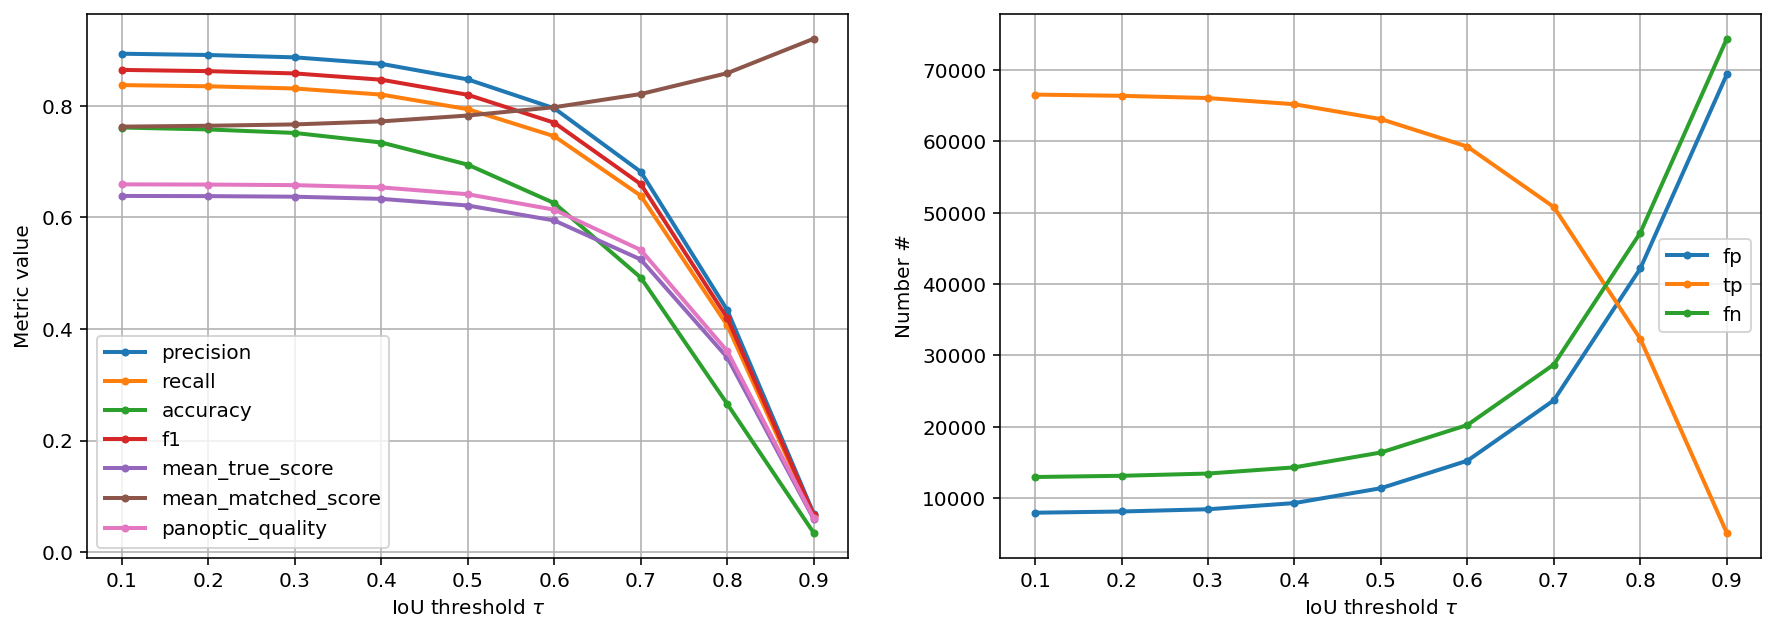

In [120]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();